# Native Space Comparison
C. Heiser, 2019

---
__The purpose of this notebook is to evaluate priming dimensionality reduction techniques with PCA versus using 500-gene space for their ability to preserve Euclidean structure of high-dimensional datasets.__  
  
To benchmark these techniques, we are using two single-cell RNAseq datasets:
* From [__Macosko, *et al* (2015)__](https://www.ncbi.nlm.nih.gov/pubmed/26000488), the mouse retina scRNA-seq data generated using DropSeq: [GSM1626793](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1626793)
* From [__Herring, *et al* (2018)__](https://www.ncbi.nlm.nih.gov/pubmed/29153838), the WT mouse colon scRNA-seq data generated using inDrops: [GSM2743164](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2743164)  
  
The first set should be __discrete__, containing highly separable cell populations from the mouse retina, where the latter will be __continuous__, representing a continuum of branching cell states in the gut epithelium.  
  
Both datasets have been __preprocessed and feature-selected__ to allow for direct input to downstream dimensionality reduction algorithms (rather than first performing PCA to limit dimensional input). These methods are shown in [`dev/QC.ipynb`](dev/QC.ipynb).

In [47]:
import sys
sys.path.append('../')
from fcc_utils import *
%matplotlib inline

In [25]:
# ignore numba deprecation warnings given by sc.pp.neighbors()
import numba
import warnings
warnings.simplefilter('ignore', numba.errors.NumbaWarning)
warnings.simplefilter('ignore', numba.errors.NumbaDeprecationWarning)
warnings.simplefilter('ignore', numba.errors.NumbaPerformanceWarning)

---
First, read in retina and colon datasets with all genes present

In [2]:
# read in Macosko retina data
retina = sc.read_text('../inputs/GSM1626793_P14Retina_1.digital_expression_filtered_CH.tsv.gz', delimiter='\t')
# read in Herring colon data
colon = sc.read_text('../inputs/GSM2743164_rep1_colon_rnaseq_filtered_CH.tsv.gz', delimiter='\t', first_column_names=True)

In [3]:
# look at dimensions of counts matrix (cells, genes)
retina

AnnData object with n_obs × n_vars = 1326 × 20478 

In [4]:
# get useful metrics of counts data
retina.var['mito'] = retina.var_names.str.contains('MT:')
sc.pp.calculate_qc_metrics(retina, qc_vars=['mito'], inplace=True)

# preprocess AnnData for downstream dimensionality reduction
retina.layers['raw_counts'] = retina.X.copy() # save raw counts in layer
sc.pp.normalize_total(retina, target_sum=1, layers=None, key_added='norm_factor') # normalize within each cell to get fractional counts
arcsinh(retina, scale=1000) # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']

# see resulting AnnData contents
retina

AnnData object with n_obs × n_vars = 1326 × 20478 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

In [5]:
# look at dimensions of counts matrix (cells, genes)
colon

AnnData object with n_obs × n_vars = 1117 × 25505 

In [6]:
# get useful metrics of counts data
colon.var['mito'] = colon.var_names.str.contains('mt-')
sc.pp.calculate_qc_metrics(colon, qc_vars=['mito'], inplace=True)

# preprocess AnnData for downstream dimensionality reduction
colon.layers['raw_counts'] = colon.X.copy() # save raw counts in layer
sc.pp.normalize_total(colon, target_sum=1, layers=None, key_added='norm_factor') # normalize within each cell to get fractional counts
arcsinh(colon, scale=1000) # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']

# see resulting AnnData contents
colon

AnnData object with n_obs × n_vars = 1117 × 25505 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

---
Next, read in feature-selected retina and colon datasets with 500 most variable genes

In [7]:
# read in Macosko retina data (feature-selected to 500 VGs)
retina_sel = sc.read_text('../inputs/GSM1626793_P14Retina_1.processed.tsv', delimiter='\t')
# read in Herring colon data (feature-selected to 500 VGs)
colon_sel = sc.read_text('../inputs/GSM2743164_rep1_colon_rnaseq.processed.tsv', delimiter='\t', first_column_names=True)

In [8]:
# look at dimensions of counts matrix (cells, genes)
retina_sel

AnnData object with n_obs × n_vars = 1326 × 500 

In [9]:
# get useful metrics of counts data
retina_sel.var['mito'] = retina_sel.var_names.str.contains('MT:')
sc.pp.calculate_qc_metrics(retina_sel, qc_vars=['mito'], inplace=True)

# preprocess AnnData for downstream dimensionality reduction
retina_sel.layers['raw_counts'] = retina_sel.X.copy() # save raw counts in layer
sc.pp.normalize_total(retina_sel, target_sum=1, layers=None, key_added='norm_factor') # normalize within each cell to get fractional counts
arcsinh(retina_sel, scale=1000) # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']

# see resulting AnnData contents
retina_sel

AnnData object with n_obs × n_vars = 1326 × 500 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

In [10]:
# look at dimensions of counts matrix (cells, genes)
colon_sel

AnnData object with n_obs × n_vars = 1117 × 500 

In [11]:
# get useful metrics of counts data
colon_sel.var['mito'] = colon_sel.var_names.str.contains('mt-')
sc.pp.calculate_qc_metrics(colon_sel, qc_vars=['mito'], inplace=True)

# preprocess AnnData for downstream dimensionality reduction
colon_sel.layers['raw_counts'] = colon_sel.X.copy() # save raw counts in layer
sc.pp.normalize_total(colon_sel, target_sum=1, layers=None, key_added='norm_factor') # normalize within each cell to get fractional counts
arcsinh(colon_sel, scale=1000) # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']

# see resulting AnnData contents
colon_sel

AnnData object with n_obs × n_vars = 1117 × 500 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

---
## PCA
Because PCA performs a __linear__ transformation on the data, 500 PCs may offer a better approximation of the 'native' space the cells reside in.  
We will compare this to the 500 selected genes in `retina_sel` and `colon_sel`.

In [12]:
retina.X = retina.layers['arcsinh_norm'].copy()
sc.tl.pca(retina, use_highly_variable=False, n_comps=500)

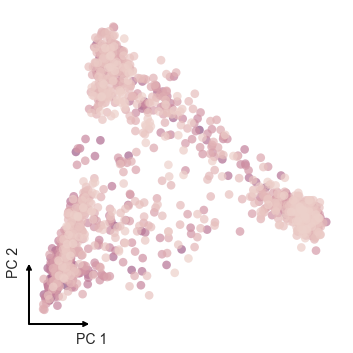

In [13]:
DR_plot(dim_name='PC').plot(retina.obsm['X_pca'], color=retina.obs['log1p_total_counts'])

Now perform same analysis on colon dataset

In [14]:
colon.X = colon.layers['arcsinh_norm'].copy()
sc.tl.pca(colon, use_highly_variable=False, n_comps=500)

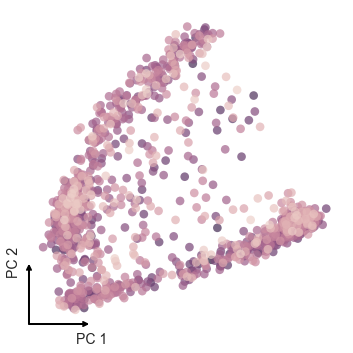

In [15]:
DR_plot(dim_name='PC').plot(colon.obsm['X_pca'], color=colon.obs['log1p_total_counts'])

---
## t-SNE
A workhorse technique for dimensionality reduction and visualization of scRNA-seq datasets, t-SNE performs a stochastic, non-linear transformation to project high-dimensional data into 2D in order to identify clustering and global structure.  
Here, we will plug arcsinh-normalized counts data directly into t-SNE and compare results to the original, feature-selected dataset.

In [16]:
retina_sel.X = retina_sel.layers['arcsinh_norm'].copy()
sc.tl.tsne(retina_sel, use_rep='X', perplexity=30, random_state=18)

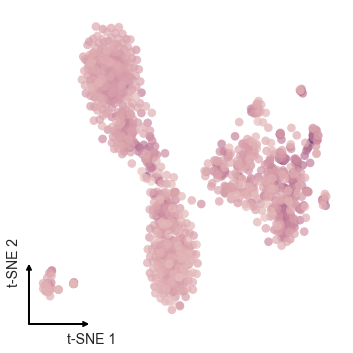

In [17]:
DR_plot(dim_name='t-SNE').plot(retina_sel.obsm['X_tsne'], color=retina_sel.obs['log1p_total_counts'])

In [18]:
sc.tl.tsne(retina, use_rep='X_pca', n_pcs=500, perplexity=30, random_state=18)

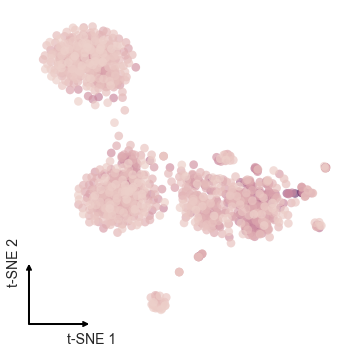

In [19]:
DR_plot(dim_name='t-SNE').plot(retina.obsm['X_tsne'], color=retina.obs['log1p_total_counts'])

Now perform same analysis on colon dataset

In [20]:
colon_sel.X = colon_sel.layers['arcsinh_norm'].copy()
sc.tl.tsne(colon_sel, use_rep='X', perplexity=30, random_state=18)

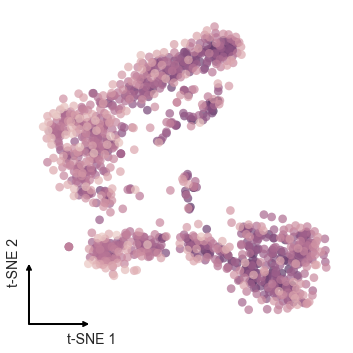

In [21]:
DR_plot(dim_name='t-SNE').plot(colon_sel.obsm['X_tsne'], color=colon_sel.obs['log1p_total_counts'])

In [22]:
sc.tl.tsne(colon, use_rep='X_pca', n_pcs=500, perplexity=30, random_state=18)

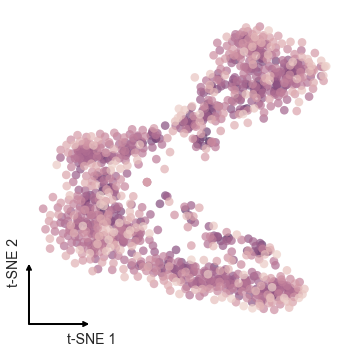

In [23]:
DR_plot(dim_name='t-SNE').plot(colon.obsm['X_tsne'], color=colon.obs['log1p_total_counts'])

---
## UMAP
Another popular method for low-dimensional projection of scRNA-seq datasets, UMAP creates high-dimensional manifolds that describe the structure of the dataset.  
Here, we will plug arcsinh-normalized counts data directly into UMAP and compare results to the original, feature-selected dataset.

In [24]:
sc.pp.neighbors(retina_sel, n_neighbors=30, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)
sc.tl.umap(retina_sel, random_state=18)

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compile

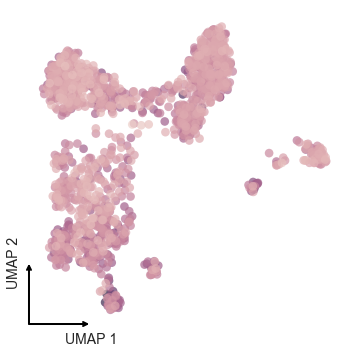

In [26]:
DR_plot(dim_name='UMAP').plot(retina_sel.obsm['X_umap'], color=retina_sel.obs['log1p_total_counts'])

In [27]:
sc.pp.neighbors(retina, n_neighbors=30, use_rep='X_pca', n_pcs=500, knn=True, random_state=18, metric='euclidean', copy=False)
sc.tl.umap(retina, random_state=18)

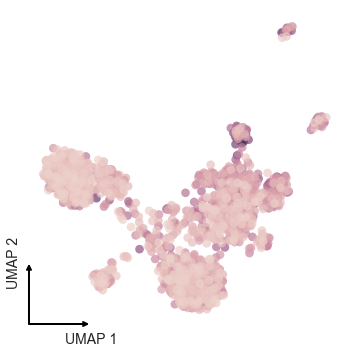

In [28]:
DR_plot(dim_name='UMAP').plot(retina.obsm['X_umap'], color=retina.obs['log1p_total_counts'])

Now perform same analysis on colon dataset

In [29]:
sc.pp.neighbors(colon_sel, n_neighbors=30, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)
sc.tl.umap(colon_sel, random_state=18)

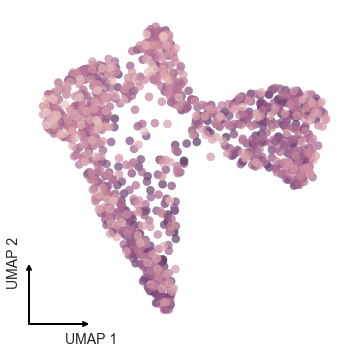

In [30]:
DR_plot(dim_name='UMAP').plot(colon_sel.obsm['X_umap'], color=colon_sel.obs['log1p_total_counts'])

In [31]:
sc.pp.neighbors(colon, n_neighbors=30, use_rep='X_pca', n_pcs=500, knn=True, random_state=18, metric='euclidean', copy=False)
sc.tl.umap(colon, random_state=18)

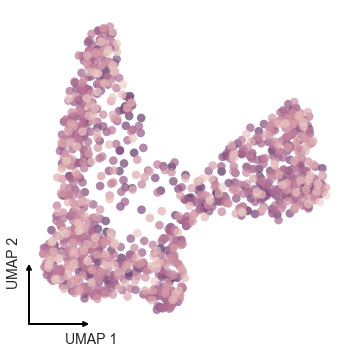

In [32]:
DR_plot(dim_name='UMAP').plot(colon.obsm['X_umap'], color=colon.obs['log1p_total_counts'])

---
We can test the Euclidean distance preservation as follows:

In [33]:
# choose value for K-nearest neighbor calculations. 
# We use 30 because that is the standard perplexity chosen for DR techniques here.
k = 30

In [34]:
# create dictionaries for dumping results into
final_distance_stats = {'Retina':{'R':{}, 'EMD':{}, 'Knn Pres.':{}}, 'Colon':{'R':{}, 'EMD':{}, 'Knn Pres.':{}}}

In [35]:
%time corr, EMD, knnP = structure_preservation_sc(retina_sel, latent='X_tsne', native='X', k=k)
final_distance_stats['Retina']['R']['t-SNE (sel.)'], final_distance_stats['Retina']['EMD']['t-SNE (sel.)'], final_distance_stats['Retina']['Knn Pres.']['t-SNE (sel.)'] = corr[0], EMD, knnP

Calculating unique distances for native space, X
Calculating unique distances for latent space, X_tsne
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
k-nearest neighbor calculation for native space, X
k-nearest neighbor calculation for latent space, X_tsne
Determining nearest neighbor preservation

Done!
CPU times: user 3.39 s, sys: 222 ms, total: 3.61 s
Wall time: 2.25 s


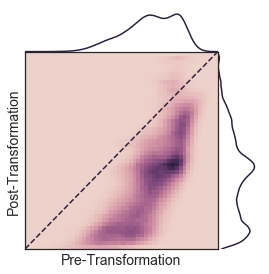

In [50]:
joint_plot_distance_correlation(retina_sel.uns['X_norm_distances'], retina_sel.uns['X_tsne_norm_distances'])

In [36]:
%time corr, EMD, knnP = structure_preservation_sc(retina, latent='X_tsne', native='X_pca', k=k)
final_distance_stats['Retina']['R']['t-SNE (PCA)'], final_distance_stats['Retina']['EMD']['t-SNE (PCA)'], final_distance_stats['Retina']['Knn Pres.']['t-SNE (PCA)'] = corr[0], EMD, knnP

Calculating unique distances for native space, X_pca
Calculating unique distances for latent space, X_tsne
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
k-nearest neighbor calculation for native space, X_pca
k-nearest neighbor calculation for latent space, X_tsne
Determining nearest neighbor preservation

Done!
CPU times: user 2.08 s, sys: 196 ms, total: 2.27 s
Wall time: 939 ms


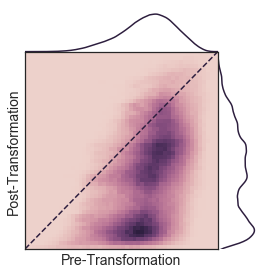

In [51]:
joint_plot_distance_correlation(retina.uns['X_pca_norm_distances'], retina.uns['X_tsne_norm_distances'])

In [37]:
%time corr, EMD, knnP = structure_preservation_sc(retina_sel, latent='X_umap', native='X', k=k)
final_distance_stats['Retina']['R']['UMAP (sel.)'], final_distance_stats['Retina']['EMD']['UMAP (sel.)'], final_distance_stats['Retina']['Knn Pres.']['UMAP (sel.)'] = corr[0], EMD, knnP

Calculating unique distances for latent space, X_umap
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
k-nearest neighbor calculation for latent space, X_umap
Determining nearest neighbor preservation

Done!
CPU times: user 967 ms, sys: 298 ms, total: 1.27 s
Wall time: 527 ms


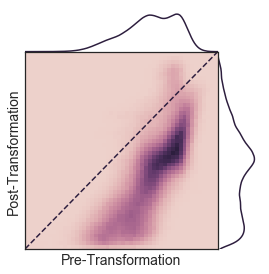

In [52]:
joint_plot_distance_correlation(retina_sel.uns['X_norm_distances'], retina_sel.uns['X_umap_norm_distances'])

In [38]:
%time corr, EMD, knnP = structure_preservation_sc(retina, latent='X_umap', native='X_pca', k=k)
final_distance_stats['Retina']['R']['UMAP (PCA)'], final_distance_stats['Retina']['EMD']['UMAP (PCA)'], final_distance_stats['Retina']['Knn Pres.']['UMAP (PCA)'] = corr[0], EMD, knnP

Calculating unique distances for latent space, X_umap
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
k-nearest neighbor calculation for latent space, X_umap
Determining nearest neighbor preservation

Done!
CPU times: user 1.06 s, sys: 272 ms, total: 1.33 s
Wall time: 580 ms


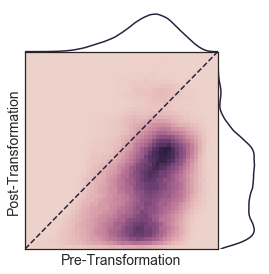

In [53]:
joint_plot_distance_correlation(retina.uns['X_pca_norm_distances'], retina.uns['X_umap_norm_distances'])

In [39]:
%time corr, EMD, knnP = structure_preservation_sc(colon_sel, latent='X_tsne', native='X', k=k)
final_distance_stats['Colon']['R']['t-SNE (sel.)'], final_distance_stats['Colon']['EMD']['t-SNE (sel.)'], final_distance_stats['Colon']['Knn Pres.']['t-SNE (sel.)'] = corr[0], EMD, knnP

Calculating unique distances for native space, X
Calculating unique distances for latent space, X_tsne
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
k-nearest neighbor calculation for native space, X
k-nearest neighbor calculation for latent space, X_tsne
Determining nearest neighbor preservation

Done!
CPU times: user 1.71 s, sys: 389 ms, total: 2.09 s
Wall time: 891 ms


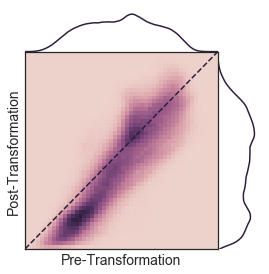

In [54]:
joint_plot_distance_correlation(colon_sel.uns['X_norm_distances'], colon_sel.uns['X_tsne_norm_distances'])

In [40]:
%time corr, EMD, knnP = structure_preservation_sc(colon, latent='X_tsne', native='X_pca', k=k)
final_distance_stats['Colon']['R']['t-SNE (PCA)'], final_distance_stats['Colon']['EMD']['t-SNE (PCA)'], final_distance_stats['Colon']['Knn Pres.']['t-SNE (PCA)'] = corr[0], EMD, knnP

Calculating unique distances for native space, X_pca
Calculating unique distances for latent space, X_tsne
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
k-nearest neighbor calculation for native space, X_pca
k-nearest neighbor calculation for latent space, X_tsne
Determining nearest neighbor preservation

Done!
CPU times: user 2.01 s, sys: 297 ms, total: 2.31 s
Wall time: 987 ms


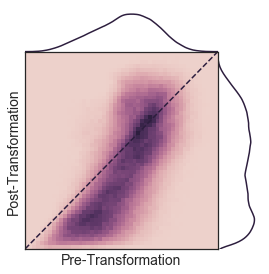

In [55]:
joint_plot_distance_correlation(colon.uns['X_pca_norm_distances'], colon.uns['X_tsne_norm_distances'])

In [41]:
%time corr, EMD, knnP = structure_preservation_sc(colon_sel, latent='X_umap', native='X', k=k)
final_distance_stats['Colon']['R']['UMAP (sel.)'], final_distance_stats['Colon']['EMD']['UMAP (sel.)'], final_distance_stats['Colon']['Knn Pres.']['UMAP (sel.)'] = corr[0], EMD, knnP

Calculating unique distances for latent space, X_umap
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
k-nearest neighbor calculation for latent space, X_umap
Determining nearest neighbor preservation

Done!
CPU times: user 878 ms, sys: 188 ms, total: 1.07 s
Wall time: 333 ms


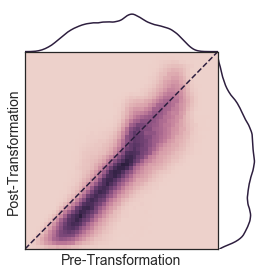

In [56]:
joint_plot_distance_correlation(colon_sel.uns['X_norm_distances'], colon_sel.uns['X_umap_norm_distances'])

In [42]:
%time corr, EMD, knnP = structure_preservation_sc(colon, latent='X_umap', native='X_pca', k=k)
final_distance_stats['Colon']['R']['UMAP (PCA)'], final_distance_stats['Colon']['EMD']['UMAP (PCA)'], final_distance_stats['Colon']['Knn Pres.']['UMAP (PCA)'] = corr[0], EMD, knnP

Calculating unique distances for latent space, X_umap
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
k-nearest neighbor calculation for latent space, X_umap
Determining nearest neighbor preservation

Done!
CPU times: user 1.03 s, sys: 189 ms, total: 1.22 s
Wall time: 383 ms


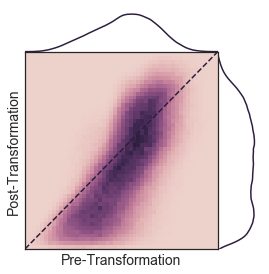

In [57]:
joint_plot_distance_correlation(colon.uns['X_pca_norm_distances'], colon.uns['X_umap_norm_distances'])

---
### Summary Metrics

In [58]:
retina_sum = pd.DataFrame(final_distance_stats['Retina'])
#retina_sum = retina_sum.sort_values(by='R')
retina_sum = retina_sum.reindex(['EMD','R','Knn Pres.'], axis=1)
#retina_sum.to_csv('retina_global_metrics.csv')

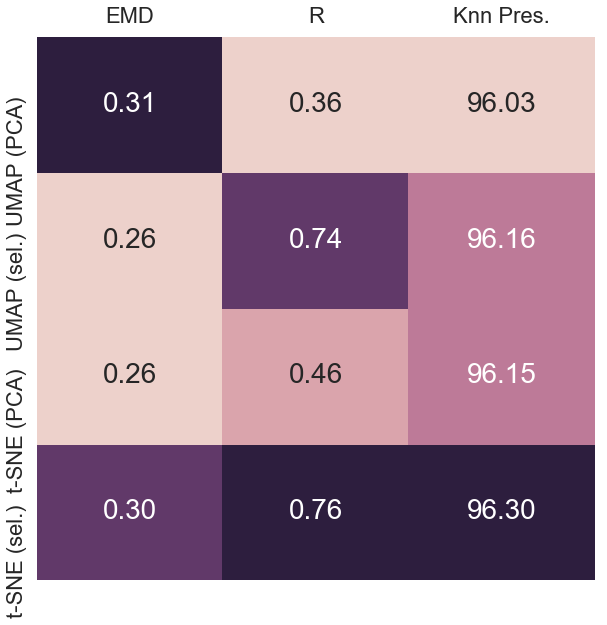

In [61]:
retina_norm=(retina_sum-retina_sum.mean())/retina_sum.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
ax = sns.heatmap(retina_norm, annot=retina_sum, cmap=sns.cubehelix_palette(), robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.tick_params(top=False)
#plt.savefig(fname='../images/retina_global_metrics.png', transparent=True, bbox_inches='tight')

In [62]:
colon_sum = pd.DataFrame(final_distance_stats['Colon'])
#colon_sum = colon_sum.sort_values(by='R')
colon_sum = colon_sum.reindex(['EMD','R','Knn Pres.'], axis=1)
#colon_sum.to_csv('colon_global_metrics.csv')

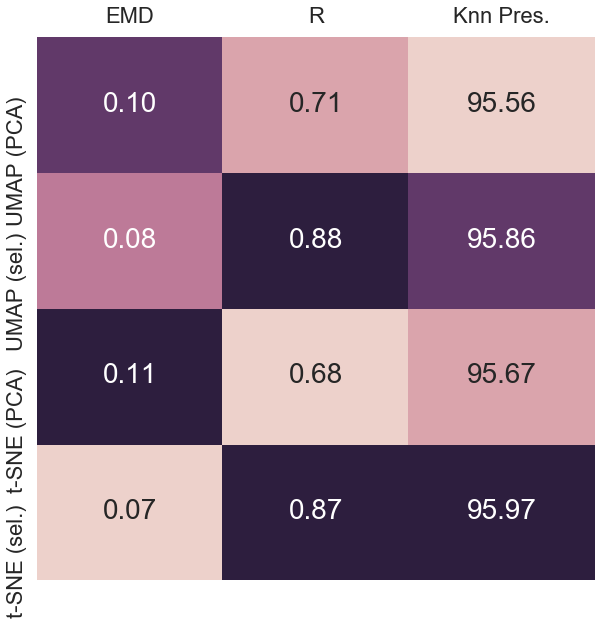

In [63]:
colon_norm=(colon_sum-colon_sum.mean())/colon_sum.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
ax = sns.heatmap(colon_norm, annot=colon_sum, cmap=sns.cubehelix_palette(), robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.tick_params(top=False)
#plt.savefig(fname='../images/colon_global_metrics.png', transparent=True, bbox_inches='tight')

In [66]:
retina_sum['DR'] = retina_sum.index

In [67]:
new = retina_sum['DR'].str.split(" ", expand=True)
retina_sum['DR'] = new[0]

In [68]:
retina_sum['Native'] = new[1]

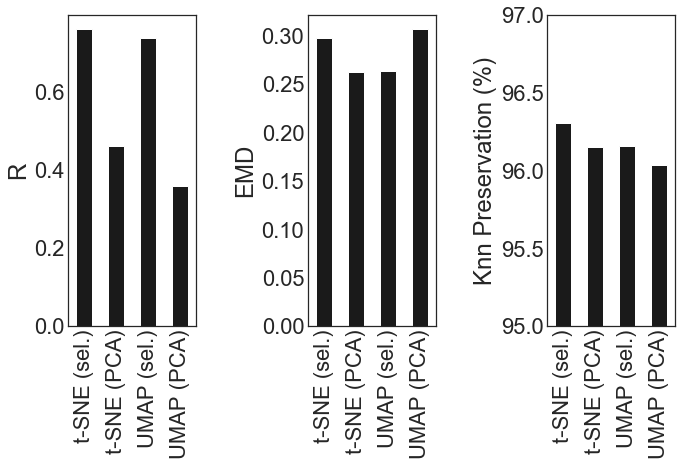

In [89]:
with plt.style.context('seaborn-white'):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,7))
    retina_sum[['R']].plot(ax=axes[0],kind='bar', legend=False, color='k')
    retina_sum[['EMD']].plot(ax=axes[1],kind='bar', legend=False, color='k')
    retina_sum[['Knn Pres.']].plot(ax=axes[2],kind='bar', legend=False, color='k')
    axes[0].set_ylabel('R')
    axes[1].set_ylabel('EMD')
    axes[2].set_ylim([95, 97])
    axes[2].set_ylabel('Knn Preservation (%)')
    plt.tight_layout()
    plt.savefig('outputs/retina_native_comparison.png', dpi=1000)

In [80]:
colon_sum['DR'] = colon_sum.index

In [81]:
new = colon_sum['DR'].str.split(" ", expand=True)
colon_sum['DR'] = new[0]

In [82]:
colon_sum['Native'] = new[1]

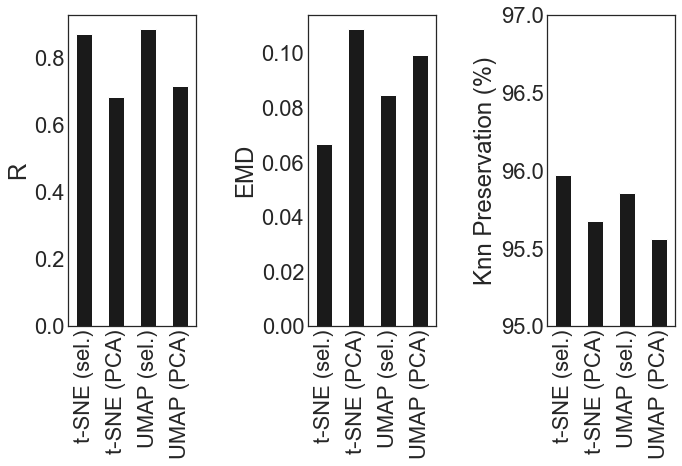

In [90]:
with plt.style.context('seaborn-white'):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,7))
    colon_sum[['R']].plot(ax=axes[0],kind='bar', legend=False, color='k')
    colon_sum[['EMD']].plot(ax=axes[1],kind='bar', legend=False, color='k')
    colon_sum[['Knn Pres.']].plot(ax=axes[2],kind='bar', legend=False, color='k')
    axes[0].set_ylabel('R')
    axes[1].set_ylabel('EMD')
    axes[2].set_ylim([95, 97])
    axes[2].set_ylabel('Knn Preservation (%)')
    plt.tight_layout()
    plt.savefig('outputs/colon_native_comparison.png', dpi=1000)